In [56]:
# Import libraries
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# Create engine
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

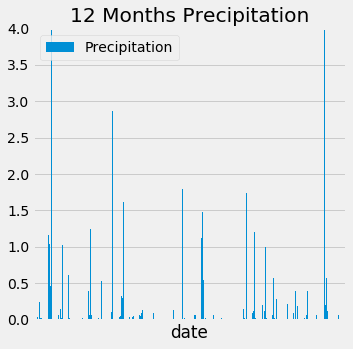

In [59]:
# Get last date from Measurement table
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')

# Get start date (12 months from last date)
startdate = last_date - dt.timedelta(days=365)

# Get precipitation data for last 12 months, aggregate and save in a data frame
date_prcp_12_months = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= startdate).all()
date_prcp_12_months_df = pd.DataFrame(date_prcp_12_months)
date_prcp_12_months_df_agg = date_prcp_12_months_df.groupby(by='date').sum()
date_prcp_12_months_df_agg = date_prcp_12_months_df.sort_values('date')

# Plot
date_prcp_12_months_df_agg.plot.bar(figsize=(5,5))
plt.ylim(0,4)
plt.xlabel('date')
plt.title("12 Months Precipitation")
plt.xticks([])
plt.legend(['Precipitation'], loc="best")
plt.show()

In [55]:
date_prcp_12_months_df_agg.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [62]:
# Number of Stations
NoOfStations = session.query(Station.id).count()
print(f'Total number of stations: {NoOfStations}')

Total number of stations: 9


In [27]:
# Active Stations - Method 1
engine.execute("SELECT s.station, COUNT(tobs) as tobscnt \
FROM Station s INNER JOIN Measurement m ON s.station=m.station \
GROUP BY s.station ORDER BY tobscnt DESC").fetchall()

# Active Stations - Method 2
active_stations = session.query(Measurement.station, func.count(Measurement.tobs)). \
filter(Station.station == Measurement.station).group_by(Station.station).order_by(func.count(Measurement.tobs).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [30]:
# Find Station with Maximum number of observations
MaxObsStation = engine.execute("SELECT s.station, COUNT(tobs) as tobscnt \
FROM Station s INNER JOIN Measurement m ON s.station=m.station \
GROUP BY s.station ORDER BY tobscnt DESC").first()[0]

print(f'Station: {MaxObsStation} has the maximum observations')

Station: USC00519281 has the maximum observations


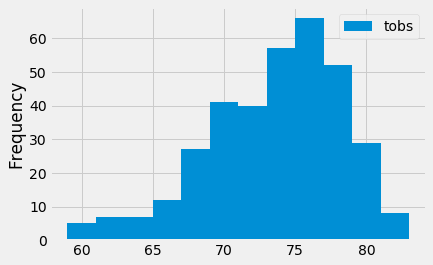

In [53]:
# Plot histogram for 12 months observation for Station with Maximum number of observations - Method 1
MaxObsStation_12months = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= startdate). \
filter(Measurement.station == MaxObsStation).all()

MaxObsStation_12months_df = pd.DataFrame(MaxObsStation_12months)

num_bins = 12
n, bins, patches = plt.hist(MaxObsStation_12months_df["tobs"], num_bins, facecolor='#008FD5')
plt.legend(['tobs'], loc="best")
plt.ylabel('Frequency')
plt.show()

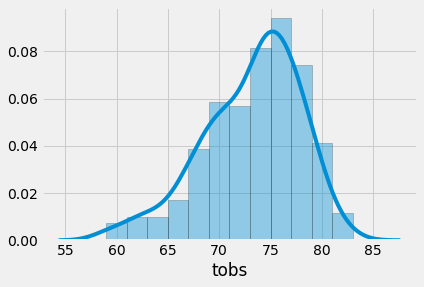

In [61]:
# Plot histogram for 12 months observation for Station with Maximum number of observations - Method 2
import seaborn as sns

sns.distplot(MaxObsStation_12months_df['tobs'], hist=True, kde=True, 
             bins=12, color = '#008FD5', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})